### Information retrieval project

Goal is to create an IR model that can perform both boolean (AND, OR and NOT), wildcard and phrase queries.

Perform normalization and stemming.

Spelling correction.

Evaluate the system on test queries.

In [126]:
import numpy as np
import pandas as pd


import re
import json
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

from nltk import word_tokenize
from nltk.corpus import stopwords

import string

import math

from collections import defaultdict


In [127]:
def read_documents():
    f = open("archive/CISI.ALL")
    merged = " "
    i = 0
    for a_line in f.readlines ():
            if a_line.startswith ("."):
                i+=1
                merged += "\n" + a_line.strip ()
            else:
                i += 1
                merged += " " + a_line.strip ()
        # updates the merged variable using a for-loop
    documents = {}
    content = ""
    doc_id = ""
    # each entry in the dictioanry contains key = doc_id and value = content

    for line in merged.split ("\n"):
        #print(a_line)
        if line.startswith (".I"):
            doc_id = line.split (" ") [1].strip()
        elif line.startswith (".X"):
            documents[doc_id] = content
            content = ""
            doc_id = ""
        else:
            content += line.strip ()[3:] + " "
            #Extract after . a letter and a space
    f.close ()
    return documents


In [128]:
def read_queries():
    f = open("archive/CISI.QRY")

    merged = ""

    for line in f.readlines ():
        if line.startswith ("."):
            merged += "\n" + line.strip ()
        else:
            merged += " " + line.strip ()
    
    queries = {}

    content = ""
    qry_id = ""

    for line in merged.split ("\n"):
        if line.startswith(".I"):
            if not content == "":
                queries [qry_id] = content
                content = ""
                qry_id = ""
            # add an enrty to the dictionary when you encounter an .I identifier
            qry_id = line.split(" ")[1].strip ()
        # otherwise, keep adding content to the content variable
        elif line.startswith (".W") or line.startswith (".T"):
            content += line.strip ()[3:] + " "
    queries [qry_id] = content
    f.close ()
    return queries


In [129]:
def read_relevance():
    f = open("archive/CISI.REL")
    mappings = {}
    
    for line in f.readlines ():
        voc = line.strip ().split ()
        key = voc[0].strip ()
        current_value = voc[1].strip()
        value = []
        # update the entry in the mappings dictionary with the current value
        if key in mappings.keys ():
            value = mappings.get (key)
        value.append (current_value)
        mappings [key] = value
    f.close ()
    return mappings

In [130]:
documents = read_documents()
print(len(documents))
print(documents["1"])


1460
 18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


In [131]:
queries = read_queries()
print(len(queries))
print(queries["1"])

112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles? 


In [132]:
print(queries)

{'1': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles? ', '2': 'How can actually pertinent data, as opposed to references or entire articles themselves, be retrieved automatically in response to information requests? ', '3': 'What is information science?  Give definitions where possible. ', '4': 'Image recognition and any other methods of automatically transforming printed text into computer-ready form. ', '5': 'What special training will ordinary researchers and businessmen need for proper information management and unobstructed use of information retrieval systems? What problems are they likely to encounter? ', '6': 'What possibilities are there for verbal communication between computers and humans, that is, communication via the spoken word? ', '7': 'Describe presently working and planned systems fo

In [133]:
relevance = read_relevance()
print(len(relevance))
print(relevance["1"])


76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '195', '215', '269', '291', '320', '429', '465', '466', '482', '483', '510', '524', '541', '576', '582', '589', '603', '650', '680', '711', '722', '726', '783', '813', '820', '868', '869', '894', '1162', '1164', '1195', '1196', '1281']


In [134]:
## INVERTED INDEX
def normalize(text):
    no_punctuation = re.sub(r'[^\w^\s*-]','',text) # remove punctuation
    downcase = no_punctuation.lower() # lowercase
    return downcase

def tokenize(content):
    text = normalize(content)
    return list(text.split()) # return a list of tokens

def Lstemm(content):
    ps = LancasterStemmer() # stemmer
    text = tokenize(content) # tokenize
    return list(set([ps.stem(word) for word in text]))
def Pstemm(content):
    ps = PorterStemmer() # stemmer
    text = tokenize(content) # tokenize
    return list(set([ps.stem(word) for word in text])) 

In [135]:
# create inverted index
def create_inverted_index_no_norm(documents):
    inverted_index = {}
    for doc_id, content in documents.items():
        for token in content.split():
            if token in inverted_index.keys():
                if doc_id not in inverted_index[token]:
                    inverted_index[token].append(doc_id)
            else:
                inverted_index[token] = [doc_id]
        #if (int(doc_id) % 100 == 0):
        #    print("ID: " + str(doc_id))
    return inverted_index

In [136]:
# create inverted index
def create_inverted_index_P(documents):
    inverted_index = {}
    for doc_id, content in documents.items():
        #print(content)
        for token in Pstemm(content):
            if token in inverted_index.keys():
                if doc_id not in inverted_index[token]:
                    inverted_index[token].append(doc_id)
            else:
                inverted_index[token] = [doc_id]
        #if (int(doc_id) % 100 == 0):
        #    print("ID: " + str(doc_id))
    return inverted_index

In [137]:
# create inverted index
def create_inverted_index_L(documents):
    inverted_index = {}
    for doc_id, content in documents.items():
        #print(content)
        for token in Lstemm(content):
            if token in inverted_index.keys():
                if doc_id not in inverted_index[token]:
                    inverted_index[token].append(doc_id)
            else:
                inverted_index[token] = [doc_id]
        #if (int(doc_id) % 100 == 0):
        #    print("ID: " + str(doc_id))
    return inverted_index

In [138]:
inv_index_no_norm = create_inverted_index_no_norm(documents)

inv_index_L = create_inverted_index_L(documents)

inv_index_P = create_inverted_index_P(documents)

print(f"Len no norm: {len(inv_index_no_norm)}")
print(f"Len L: {len(inv_index_L)}")
print(f"Len P: {len(inv_index_P)}")

Len no norm: 21967
Len L: 7556
Len P: 8554


In [139]:
def order_inverted_index(inverted_index):
    ordered_inverted_index = {}
    for key in sorted(inverted_index.keys()):
        ordered_inverted_index[key] = inverted_index[key]
    return ordered_inverted_index

ordered = order_inverted_index(inv_index_no_norm)

In [140]:
inv_index_P.get("class")

['5',
 '16',
 '42',
 '176',
 '233',
 '275',
 '282',
 '290',
 '328',
 '341',
 '345',
 '363',
 '379',
 '404',
 '405',
 '417',
 '428',
 '455',
 '476',
 '478',
 '479',
 '486',
 '559',
 '577',
 '610',
 '669',
 '694',
 '701',
 '722',
 '769',
 '791',
 '797',
 '798',
 '838',
 '857',
 '862',
 '945',
 '954',
 '958',
 '1029',
 '1075',
 '1180',
 '1204',
 '1217',
 '1237',
 '1380',
 '1395',
 '1398',
 '1415',
 '1423']

### BOOLEAN QUERIES

In [141]:
def stemm(book):
    ps = PorterStemmer() # stemmer
    text = tokenize(book) # tokenize
    return list(set([ps.stem(word) for word in text])) 

def build_ngram_inverted_index(documents, n): # function take in input the documents and the n-gram size
    inverted_index = {}
    print("Building ngram inverted index...")
    for doc_id, doc in enumerate(documents): # for each document
        for token in stemm(doc): # for each token in the document
            wild_token = "$" + token + "$" # add initial and final symbol
            for i in range(len(wild_token) - n + 1): # for each ngram in the token
                ngram = wild_token[i:i+n]  # extract the n-gram
                if ngram not in inverted_index:
                    inverted_index[ngram] = [] # if the ngram is not in the inverted index we add it
                if token not in inverted_index[ngram]:
                    inverted_index[ngram].append(token) # if the token is not in the inverted index we add it to the list of tokens for that ngram    
        if (doc_id % 1000 == 0):
                print("ID: " + str(doc_id))
    return inverted_index


In [142]:
n_gram_inv_index = build_ngram_inverted_index(documents.values(), 3)

Building ngram inverted index...
ID: 0
ID: 1000


In [143]:
# SPELLING CORRECTION using Jaccard similarity
def ngrams(word, n):
    return [word[i:i+n] for i in range(len(word)-n+1)]

def spelling_correction(word, index):    
    # Get the list of k-grams for the input word
    word_ngrams = ngrams("$" + word + "$", 3)
    # Build a set of all words that have any of these k-grams
    words_with_kgrams = set()
    for ngram in word_ngrams:
        try: # check if What are the benefits of appl* or banana?ngram is in inverted index, if not, pass
            words_with_kgrams.update(index[ngram]) 
        except KeyError:
            pass
        
    # Compute the Jaccard similarity coefficient for each candidate word,
    # and take the one that maximizes it
    scores = []
    for w in words_with_kgrams: # for each word in the set of words with k-grams
        w_ngrams = ngrams("$" + w + "$", 3) # get the list of k-grams for the word
        scores.append((w, len(set(word_ngrams).intersection(w_ngrams)) / len(set(word_ngrams).union(w_ngrams)))) # compute the Jaccard similarity coefficient and append it to the list of scores  
    return max(scores, key=lambda x: x[1])[0] # return the word with the highest Jaccard similarity coefficient


In [145]:
import re
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def tokenize_query(query):
    """
    Splits the query into tokens (terms, operators, and parentheses).
    Operators are normalized to uppercase.
    Terms are lowercased and stemmed using the Porter Stemmer.
    """
    # This regex captures words, parentheses, and Boolean operators.
    tokens = re.findall(r'\(|\)|\bAND\b|\bOR\b|\bNOT\b|\w+', query, flags=re.IGNORECASE)
    normalized_tokens = []
    for token in tokens:
        # Check if token is an operator
        if token.upper() in {"AND", "OR", "NOT"}:
            normalized_tokens.append(token.upper())
        elif token in {"(", ")"}:
            normalized_tokens.append(token)
        else:
            # For terms, lowercase and apply stemming
            token = stemmer.stem(token.lower())
            if token not in inv_index_P.keys():
                token = spelling_correction(token, n_gram_inv_index)
            normalized_tokens.append(token)

    return normalized_tokens

def shunting_yard(tokens):
    """
    Converts infix expression tokens to postfix (RPN) using the Shunting-yard algorithm.
    Operator precedence: NOT > AND > OR.
    """
    output = []
    op_stack = []
    precedence = {"NOT": 3, "AND": 2, "OR": 1}
    
    for token in tokens:
        if token in {"AND", "OR", "NOT"}:
            # Pop operators with higher or equal precedence
            while (op_stack and op_stack[-1] != "(" and 
                   op_stack[-1] in precedence and 
                   precedence[op_stack[-1]] >= precedence[token]):
                output.append(op_stack.pop())
            op_stack.append(token)
        elif token == "(":
            op_stack.append(token)
        elif token == ")":
            # Pop until an '(' is encountered
            while op_stack and op_stack[-1] != "(":
                output.append(op_stack.pop())
            if op_stack and op_stack[-1] == "(":
                op_stack.pop()  # Remove the '('
            else:
                raise ValueError("Mismatched parentheses in query.")
        else:
            output.append(token)
    
    while op_stack:
        op = op_stack.pop()
        if op in {"(", ")"}:
            raise ValueError("Mismatched parentheses in query.")
        output.append(op)
    
    return output

def evaluate_postfix(postfix_tokens, inverted_index, universal_set):
    """
    Evaluates the Boolean query given in postfix notation.
    Returns a set of document IDs matching the query.
    """
    stack = []
    for token in postfix_tokens:
        if token in {"AND", "OR", "NOT"}:
            if token == "NOT":
                if not stack:
                    raise ValueError("Insufficient operands for NOT operator.")
                operand = stack.pop()
                result = universal_set - operand
                stack.append(result)
            else:
                if len(stack) < 2:
                    raise ValueError(f"Insufficient operands for {token} operator.")
                right = stack.pop()
                left = stack.pop()
                if token == "AND":
                    result = left & right  # Intersection
                elif token == "OR":
                    result = left | right  # Union
                stack.append(result)
        else:

            posting = inverted_index.get(token, set())
            stack.append(posting)
    
    if len(stack) != 1:
        raise ValueError(f"Error in evaluation: stack should have exactly one element, but got {stack}")
    
    return stack[0]

def evaluate_boolean_query(query, inverted_index, universal_set):
    """
    Processes a Boolean query:
      1. Tokenizes the query (with stemming).
      2. Converts it to postfix notation.
      3. Evaluates the postfix expression.
    Returns a set of document IDs that satisfy the query.
    """
    tokens = tokenize_query(query)
    postfix = shunting_yard(tokens)
    result = evaluate_postfix(postfix, inverted_index, universal_set)
    return result 

universal_set = set(range(1, 1461))

queries2 = [
    "NOT class AND gam"
]
converted_index = {term: set(map(int, doc_ids)) for term, doc_ids in inv_index_P.items()}

for query in queries2:
    try:
        result = evaluate_boolean_query(query, converted_index, universal_set)
        print(f"Query: {query}\nMatching Documents: {result}\n")
    except ValueError as ve:
        print(f"Query: {query}\nError: {ve}\n")


Query: NOT class AND gam
Matching Documents: {291, 205}



### PHRASE QUERIES

In [78]:
def extract_term_frequencies(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    term_counts = defaultdict(int)

    words = word_tokenize(text.lower())
    filtered_words = [stemmer.stem(word) for word in words if word not in string.punctuation and word not in stop_words]

    for word in filtered_words:
        term_counts[word] += 1
    
    return dict(term_counts)

doc_terms = {doc_id: extract_term_frequencies(text) for doc_id, text in documents.items()}
qry_terms = {qry_id: extract_term_frequencies(text) for qry_id, text in queries.items()}


In [79]:
print (len (doc_terms))  # number of documents
print (doc_terms.get ("28"))  # terms in document 1
print (len (doc_terms.get("28")))  # number of terms in document 1
print (len (qry_terms)) # number of queries
print (qry_terms.get("1")) # terms in query 1
print (len (qry_terms.get("1"))) # number of terms in query 1

1460
{'note': 1, 'pseudo-mathemat': 1, 'relev': 6, 'taub': 1, 'm.': 1, 'recent': 1, 'number': 1, 'articl': 1, 'book': 1, 'report': 2, 'deal': 1, 'inform': 2, 'system': 5, 'i.e.': 1, 'document': 2, 'retriev': 1, 'advanc': 1, 'doctrin': 2, 'evalu': 1, 'term': 6, 'degre': 1, 'percentag': 1, 'provid': 2, 'although': 1, 'seem': 1, 'littl': 1, 'agreement': 2, 'mean': 3, 'doubt': 1, 'quantifi': 1, 'nevertheless': 1, 'grow': 1, 'fix': 1, 'formal': 1, 'relationship': 1, 'exist': 1, 'recal': 2, 'perform': 1, 'thu': 1, 'find': 1, 'literatur': 1, 'frankli': 1, 'subject': 2, 'notion': 1, 'individu': 1, 'user': 2, 'equat': 2, 'curv': 1, 'mathemat': 4, 'formul': 1, 'presum': 1, 'numer': 1, 'measur': 1, 'characterist': 1, 'phenomenon': 1, 'shift': 1, 'back': 1, 'forth': 1, 'admittedli': 1, 'non-mathemat': 1, 'given': 1, 'valu': 1, 'definit': 1, 'ancient': 1, 'parallel': 1, 'discuss': 1, 'probabl': 1, 'one': 1, 'cours': 1, 'legisl': 1, 'depend': 1, 'alic': 1, 'point': 1, '``': 1, 'master': 1, "''": 1, 

Creo vocabolario con tutte le parole (sia dai documenti che dalle query).

Creo vettori per ogni documento e query, questi vettori rappresentano la frequenza di ogni parola all'interno di un documento/query.




In [83]:
def collect_vocabulary():
    all_terms = set()
    
    for terms in doc_terms.values():
        all_terms.update(terms.keys())

    for terms in qry_terms.values():
        all_terms.update(terms.keys())

    return sorted(all_terms)

# Print vocabulary size and first 10 terms
all_terms = collect_vocabulary()
print(len(all_terms))
print(all_terms[:10])

def vectorize(input_features, vocabulary):
    return {
        item_id: [input_features[item_id].get(word, 0) for word in vocabulary]
        for item_id in input_features
    }

doc_vectors = vectorize(doc_terms, all_terms)
qry_vectors = vectorize(qry_terms, all_terms)

# Print statistics
print(len(doc_vectors))
print(len(doc_vectors.get("1", [])))
print(len(qry_vectors))
print(len(qry_vectors.get("110", [])))


8742
["''", "'60", "'70", "'anyhow", "'appar", "'basic", "'better", "'bibliograph", "'bibliometr", "'build"]
1460
8742
112
8742


In [81]:
relevance = read_relevance()
print(len(relevance))
print(relevance["1"])

76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '195', '215', '269', '291', '320', '429', '465', '466', '482', '483', '510', '524', '541', '576', '582', '589', '603', '650', '680', '711', '722', '726', '783', '813', '820', '868', '869', '894', '1162', '1164', '1195', '1196', '1281']


In [149]:
import math
from operator import itemgetter

# Calculate vector length (Euclidean norm)
def vector_length(vector):  # norma euclidea
    return math.sqrt(sum(x ** 2 for x in vector))

# Calculate dot product of two vectors
def dot_product(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Vectors have mismatched dimensions.")
    return sum(x * y for x, y in zip(vector1, vector2) if x != 0 and y != 0)

# Compute cosine similarity
def calculate_cosine(query, document):
    return dot_product(query, document) / (vector_length(query) * vector_length(document))

# Calculate precision
def calculate_precision(model_output, gold_standard):
    return sum(1 for item in model_output if item in gold_standard) / len(model_output)

# Check if any relevant document is found
def calculate_found(model_output, gold_standard):
    return float(any(item in gold_standard for item in model_output))

def calculate_recall(model_output, gold_standard):
    return sum(1 for item in model_output if item in gold_standard) / len(gold_standard)

# Initialize precision and found metrics
precision_all, found_all = 0.0, 0.0

precisions = []
recalls = []

# Process all queries
for query_id, gold_standard in relevance.items():
    query_vector = qry_vectors.get(str(query_id))
    if query_vector is None:
        continue

    # Compute cosine similarity for all documents
    results = {
        doc_id: calculate_cosine(query_vector, doc_vector)
        for doc_id, doc_vector in doc_vectors.items()
    }

    # Get top 5 most relevant documents
    model_output = [doc_id for doc_id, _ in sorted(results.items(), key=itemgetter(1), reverse=True)[:5]]

    # Compute precision and found metrics
    precision = calculate_precision(model_output, gold_standard)
    recall=calculate_recall(model_output, gold_standard)

    found = calculate_found(model_output, gold_standard)

    print(f"{query_id} : {precision:.4f}")
    #print(f"{query_id} : {found:.4f}")

    precision_all += precision
    found_all += found

    precisions.append(precision)
    recalls.append(recall)

# Compute mean precision and found ratio
num_queries = len(relevance)
print(f"Mean Precision: {precision_all / num_queries:.4f}")
print(f"Mean Found Ratio: {found_all / num_queries:.4f}")


1 : 1.0000
2 : 0.2000
3 : 1.0000
4 : 0.0000
5 : 0.2000
6 : 0.0000
7 : 0.0000
8 : 0.0000
9 : 0.2000
10 : 0.2000
11 : 0.8000
12 : 0.4000
13 : 0.6000
14 : 0.0000
15 : 0.0000
16 : 0.0000
17 : 0.0000
18 : 0.2000
19 : 0.2000
20 : 0.4000
21 : 0.0000
22 : 0.2000
23 : 0.6000
24 : 0.8000
25 : 0.0000
26 : 0.8000
27 : 0.4000
28 : 0.0000
29 : 0.2000
30 : 0.4000
31 : 0.2000
32 : 0.6000
33 : 0.0000
34 : 0.4000
35 : 0.0000
37 : 0.4000
39 : 0.2000
41 : 0.2000
42 : 0.6000
43 : 0.2000
44 : 0.8000
45 : 0.4000
46 : 0.6000
49 : 0.0000
50 : 0.8000
52 : 0.8000
54 : 0.4000
55 : 0.6000
56 : 0.0000
57 : 0.0000
58 : 0.8000
61 : 0.0000
62 : 0.6000
65 : 0.6000
66 : 0.6000
67 : 0.2000
69 : 0.2000
71 : 0.0000
76 : 0.8000
79 : 0.2000
81 : 0.2000
82 : 0.6000
84 : 0.0000
90 : 0.0000
92 : 0.2000
95 : 0.4000
96 : 0.0000
97 : 0.2000
98 : 0.4000
99 : 0.2000
100 : 0.0000
101 : 0.0000
102 : 0.8000
104 : 0.0000
109 : 0.0000
111 : 0.6000
Mean Precision: 0.3105
Mean Found Ratio: 0.6711


In [148]:
print(found_all)

51.0


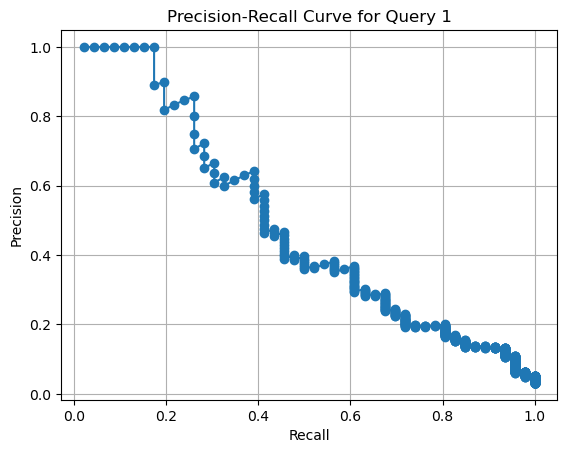

In [100]:
import matplotlib.pyplot as plt
from operator import itemgetter

# Select the first query's gold standard
query_id = list(relevance.keys())[0]  # First query
gold_standard = relevance.get(str(query_id))  # Relevance set for the first query

# Get the query vector
query_vector = qry_vectors.get(str(query_id))
if query_vector is None:
    print("Query vector not found.")
    exit()

# Compute cosine similarity for all documents
results = {
    doc_id: calculate_cosine(query_vector, doc_vector)
    for doc_id, doc_vector in doc_vectors.items()
}

# Sort documents by relevance based on cosine similarity
sorted_docs = sorted(results.items(), key=itemgetter(1), reverse=True)

# Lists to store precision and recall for different k values
precision_values = []
recall_values = []

# Calculate precision and recall for different top-k values (from 1 to N)
for k in range(1, len(sorted_docs) + 1):
    model_output = [doc_id for doc_id, _ in sorted_docs[:k]]

    # Calculate precision and recall for this k
    precision = calculate_precision(model_output, gold_standard)
    recall = calculate_recall(model_output, gold_standard)

    # Append the values to the lists
    precision_values.append(precision)
    recall_values.append(recall)

# Plot the Precision-Recall curve for the first query
plt.plot(recall_values, precision_values, marker='o')
plt.title(f"Precision-Recall Curve for Query {query_id}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


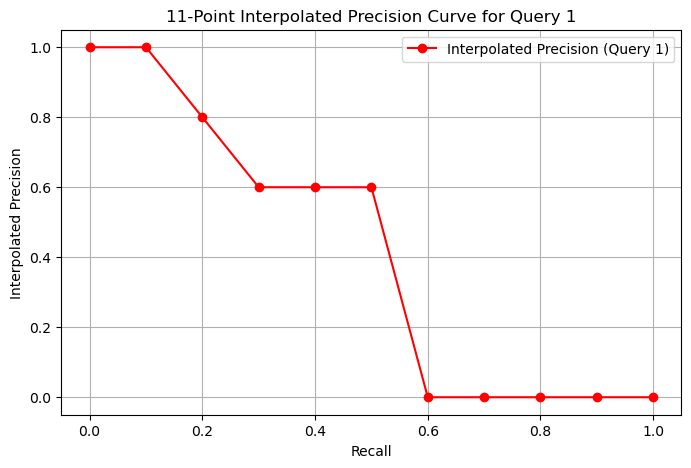

In [147]:
import numpy as np
import matplotlib.pyplot as plt

def interpolated_precision_at_k(precision_values, recall_values):
    """
    Compute the 11-point interpolated precision curve.
    
    :param precision_values: List of precision values at each rank
    :param recall_values: List of recall values at each rank
    :return: Dictionary of interpolated precision values at 11 recall levels
    """
    recall_levels = np.linspace(0, 1, 11)  # 11 standard recall levels: 0.0, 0.1, ..., 1.0
    interpolated_precisions = []

    for r_level in recall_levels:
        max_precision = max([p for p, r in zip(precision_values, recall_values) if r >= r_level], default=0)
        interpolated_precisions.append(max_precision)

    return recall_levels, interpolated_precisions

# Select a specific query (e.g., query ID "1")
query_id = "1"
gold_standard = relevance.get(query_id, set())  # Get relevant docs for this query
model_output = sorted(results.items(), key=itemgetter(1), reverse=True)[:10]  # Top-10 retrieved docs
model_output = [doc_id for doc_id, _ in model_output]  # Extract document IDs

# Compute Precision-Recall values

# Compute 11-point interpolated precision
recall_levels, interpolated_precisions = interpolated_precision_at_k(precisions, recalls)

# Plot Interpolated Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recall_levels, interpolated_precisions, marker='o', linestyle='-', color='r', label=f'Interpolated Precision (Query {query_id})')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.title(f'11-Point Interpolated Precision Curve for Query {query_id}')
plt.legend()
plt.grid()
plt.show()


In [146]:
if "is" in inv_index_P.keys():
    print(inv_index_P.get("is"))

['1', '2', '3', '5', '6', '8', '10', '11', '14', '16', '17', '18', '19', '20', '21', '22', '24', '25', '26', '28', '29', '30', '31', '34', '37', '38', '40', '42', '43', '44', '46', '47', '48', '49', '51', '52', '56', '58', '60', '61', '62', '63', '64', '65', '66', '67', '68', '70', '71', '72', '74', '76', '77', '78', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '92', '93', '94', '96', '97', '98', '99', '100', '101', '102', '103', '104', '108', '109', '110', '113', '114', '115', '116', '117', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '147', '148', '150', '151', '153', '154', '155', '156', '158', '159', '160', '161', '163', '165', '166', '168', '173', '174', '175', '176', '177', '180', '182', '185', '186', '187', '188', '189', '190', '191', '192', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '207', '208'

In [91]:
documents["28"]

'A Note on the Pseudo-Mathematics of Relevance Taube, M. Recently a number of articles, books, and reports dealing with information systems, i.e., document retrieval systems, have advanced the doctrine that such systems are to be evaluated in terms of the degree or percentage of relevancy they provide. Although there seems to be little agreement on what relevance means, and some doubt that it is quantifiable, there is, nevertheless, a growing agreement that a fixed and formal relationship exists between the relevance and the recall performance of any system.  Thus, we will find in the literature both a frankly subjective notion of relevance as reported by individual users, and equations, curves, and mathematical formulations which presumably provide numerical measures of the recall and relevance characteristics of information systems.  This phenomenon of shifting back and forth from an admittedly subjective and non-mathematical term to equations in which the same term is given a mathem

In [98]:
doc_terms["28"]["a"]

12

In [92]:
inv_index_P["relev"]

['28',
 '35',
 '42',
 '43',
 '47',
 '58',
 '61',
 '65',
 '70',
 '74',
 '84',
 '86',
 '89',
 '135',
 '151',
 '156',
 '165',
 '174',
 '186',
 '194',
 '202',
 '303',
 '319',
 '368',
 '379',
 '384',
 '386',
 '398',
 '399',
 '426',
 '444',
 '445',
 '447',
 '449',
 '456',
 '466',
 '481',
 '486',
 '487',
 '489',
 '492',
 '503',
 '506',
 '510',
 '516',
 '518',
 '519',
 '523',
 '530',
 '532',
 '553',
 '554',
 '556',
 '557',
 '562',
 '566',
 '568',
 '576',
 '603',
 '623',
 '633',
 '652',
 '659',
 '660',
 '666',
 '713',
 '733',
 '738',
 '740',
 '747',
 '754',
 '759',
 '762',
 '770',
 '773',
 '785',
 '786',
 '792',
 '797',
 '801',
 '806',
 '807',
 '810',
 '813',
 '820',
 '825',
 '826',
 '832',
 '845',
 '894',
 '934',
 '935',
 '956',
 '965',
 '966',
 '1005',
 '1038',
 '1054',
 '1091',
 '1114',
 '1119',
 '1120',
 '1124',
 '1127',
 '1138',
 '1139',
 '1146',
 '1188',
 '1195',
 '1212',
 '1213',
 '1217',
 '1230',
 '1281',
 '1339',
 '1365',
 '1398',
 '1415',
 '1427',
 '1443']

In [ ]:
# remove stopwords from the inverted index
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def remove_stopwords(inverted_index, stop_words):
    return {term: doc_ids for term, doc_ids in inverted_index.items() if term not in stop_words}

inv_index_no_stopwords = remove_stopwords(inv_index_P, stop_words)


In [110]:
qry_terms

{'1': {'what': 3,
  'problem': 1,
  'and': 1,
  'concern': 1,
  'are': 2,
  'there': 1,
  'in': 2,
  'make': 1,
  'up': 1,
  'descript': 1,
  'titl': 3,
  'difficulti': 1,
  'involv': 1,
  'automat': 1,
  'retriev': 1,
  'articl': 2,
  'from': 1,
  'approxim': 1,
  'is': 1,
  'the': 2,
  'usual': 1,
  'relev': 1,
  'of': 2,
  'content': 1,
  'to': 1,
  'their': 1},
 '2': {'how': 1,
  'can': 1,
  'actual': 1,
  'pertin': 1,
  'data': 1,
  'as': 1,
  'oppos': 1,
  'to': 2,
  'refer': 1,
  'or': 1,
  'entir': 1,
  'articl': 1,
  'themselv': 1,
  'be': 1,
  'retriev': 1,
  'automat': 1,
  'in': 1,
  'respons': 1,
  'inform': 1,
  'request': 1},
 '3': {'what': 1,
  'is': 1,
  'inform': 1,
  'scienc': 1,
  'give': 1,
  'definit': 1,
  'where': 1,
  'possibl': 1},
 '4': {'imag': 1,
  'recognit': 1,
  'and': 1,
  'ani': 1,
  'other': 1,
  'method': 1,
  'of': 1,
  'automat': 1,
  'transform': 1,
  'print': 1,
  'text': 1,
  'into': 1,
  'computer-readi': 1,
  'form': 1},
 '5': {'what': 2,
  's

In [108]:
qry_terms["2"]

{'how': 1,
 'can': 1,
 'actual': 1,
 'pertin': 1,
 'data': 1,
 'as': 1,
 'oppos': 1,
 'to': 2,
 'refer': 1,
 'or': 1,
 'entir': 1,
 'articl': 1,
 'themselv': 1,
 'be': 1,
 'retriev': 1,
 'automat': 1,
 'in': 1,
 'respons': 1,
 'inform': 1,
 'request': 1}